# Importing configurations and modules

In [1]:
import numpy as np
import pandas as pd
import tf_keras as keras
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import TfidfVectorizer

from tf_keras.layers import TextVectorization,Embedding,Dense,Conv1D,GlobalAveragePooling1D
from tf_keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import tensorflow as tf
from tf_keras.optimizers import Adam

2024-11-26 20:58:46.785968: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 20:58:46.959774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732634927.055001  639403 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732634927.090771  639403 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 20:58:47.335926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from config.config import *
from callbacks.callbacks import *
from evaluation import get_cm_and_final_results

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-3c98d5c3-b19e-acfa-02d3-5c9d5dfaedd2)


# Data processing and understanding

In [4]:
DATA_DIR = DATASET_DIR.joinpath('pubmed-rct')

In [5]:
os.listdir(DATA_DIR)

['PubMed_200k_RCT',
 'PubMed_20k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign']

In [6]:
DATASET = 'PubMed_20k_RCT_numbers_replaced_with_at_sign'
DATA_FILES = [DATA_DIR.joinpath(DATASET).joinpath(x) for x in os.listdir(DATA_DIR.joinpath(DATASET))]

In [7]:
DATA_FILES

[PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')]

In [8]:
data = dict()
for path in DATA_FILES:
    with open(path) as file:
        data[file.name.split('/')[-1].split('.')[0]] = file.readlines()

In [9]:
data.keys()

dict_keys(['test', 'train', 'dev'])

In [10]:
start = 0
amount = 20
for key in data:
    print('--------------------------------------------------------------------------------------------------\nData from Dataset', key)
    print(np.array(data[key][start: start+amount]))

--------------------------------------------------------------------------------------------------
Data from Dataset test
['###24845963\n'
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n'
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n'
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n'
 "RESULTS\tT

## To be more computer friendlty let's preprocess using a function

In [11]:
def process_data(file_name : str) -> list:
    """
    Process a structured text file containing abstracts and convert it into a list of dictionaries.

    Parameters:
        file_name: str
            Path to the input file.
            Expected file format:
            - Abstract headers marked with '###' followed by ID
            - Each line contains tab-separated target and text
            - Abstracts separated by blank lines

    Returns:
        List[Dict[str, Union[str, int]]]: A list of dictionaries, where each dictionary contains:
            - target (str): The target label from the input
            - text (str): The lowercase text content
            - line_number (int): Line position within the abstract (0-based)
            - total_lines (int): Total number of lines in the abstract
            - abstract_id (int): ID extracted from the abstract header

    Raises:
        FileNotFoundError: If the specified file does not exist
        IOError: If there are issues reading the file
        ValueError: If:
            - Abstract ID cannot be converted to integer
            - Line doesn't contain enough tab-separated fields
            - Malformed header line (missing '###' or ID)
        IndexError: If trying to access parts of malformed lines
        TypeError: If file_name is not a string

    Example:
        >>> data = process_data('abstracts.txt')
        >>> print(data[0])
        {
            'target': 'BACKGROUND',
            'text': 'example text here',
            'line_number': 0,
            'total_lines': 5,
            'abstract_id': 1234
        }

    Notes:
        - Text is automatically converted to lowercase for processing efficiency
        - Abstract headers must start with '###' followed by ID
        - Each abstract must end with a blank line
        - Lines must contain at least two tab-separated fields
    """
    data = list()
    with open(file_name) as file:
        data_lines = file.readlines()
    for line in data_lines:
        if line[:3] == '###':
            line_number = 0
            id = line[4:-2]
            abstract = []
            continue
        elif line == '\n':
            for item in abstract:
                item['total_lines'] = line_number
                data.append(item)
        else:
            target, text = line.split('\t')[:2]
            abstract.append(
                {
                    'target' : target,
                    'text' : text.lower().strip('\n'), #lowercase for efficiency
                    'line_number' : line_number,
                    'total_lines' : 0,
                    'abstract_id' : int(id)
                    }
            )
        line_number+=1
    return data

In [12]:
%%time

test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])

len(test) ,len(train), len(val)

CPU times: user 297 ms, sys: 112 ms, total: 409 ms
Wall time: 399 ms


(30135, 180040, 30212)

In [13]:
test = process_data(DATA_FILES[0])
train = process_data(DATA_FILES[1])
val = process_data(DATA_FILES[2])
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
val_df = pd.DataFrame(val)

## Visualizing the processed data

In [14]:
train_df.head(20)

,target,text,line_number,total_lines,abstract_id
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12,429357
1,METHODS,a total of @ patients with primary knee oa wer...,1,12,429357
2,METHODS,outcome measures included pain reduction and i...,2,12,429357
3,METHODS,pain was assessed using the visual analog pain...,3,12,429357
4,METHODS,secondary outcome measures included the wester...,4,12,429357
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12,429357
6,RESULTS,there was a clinically relevant reduction in t...,6,12,429357
7,RESULTS,the mean difference between treatment arms ( @...,7,12,429357
8,RESULTS,"further , there was a clinically relevant redu...",8,12,429357
9,RESULTS,these differences remained significant at @ we...,9,12,429357


In [15]:
NUM_CLASSES = train_df['target'].nunique()
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [16]:
def word_count(text : str):
    return len([x for x in text.split()])

word_counts = train_df['text'].apply(word_count)

<Axes: ylabel='Frequency'>

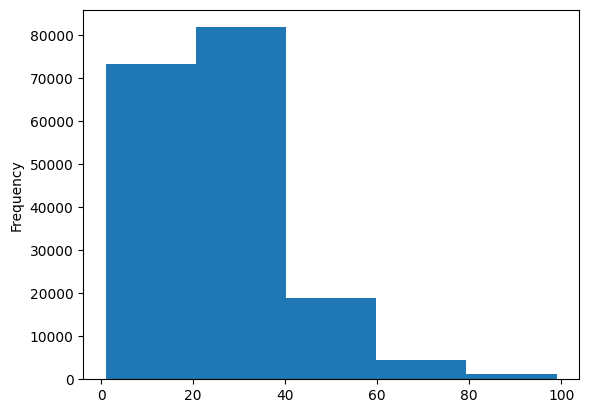

In [17]:
word_counts[word_counts < 100].plot.hist(bins = 5)

<Axes: ylabel='Frequency'>

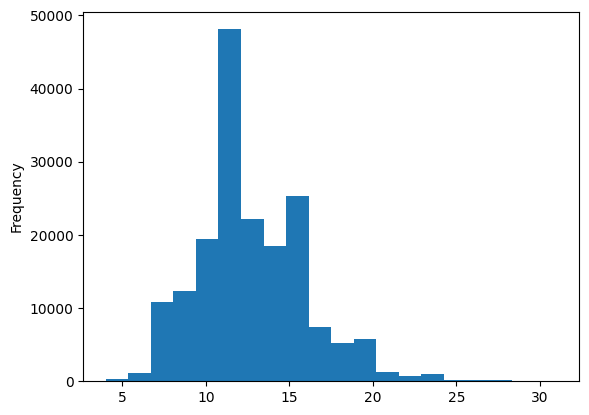

In [18]:
train_df.total_lines.plot.hist(bins = 20)

In [19]:
X_train = train_df['text'].to_list()
X_test = test_df['text'].to_list()
X_val = val_df['text'].to_list()

## Converting labels to numerical format

### One Hot

In [20]:
# Same results using sklearn
one_hot = OneHotEncoder(sparse_output=False)
train_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))
val_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

In [21]:
train_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoding

In [22]:
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['target'].to_numpy())
test_label = label_encoder.transform(test_df['target'].to_numpy())
val_label = label_encoder.transform(val_df['target'].to_numpy())

In [23]:
train_label

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
CLASS_NAMES  = label_encoder.classes_

In [25]:
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Creating Model Baseline

In [26]:
model_0 = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer()),
        ( 'clf', MultinomialNB())
    ]
)

In [27]:
model_0.fit(X_train, train_label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_preds = model_0.predict(X_val)

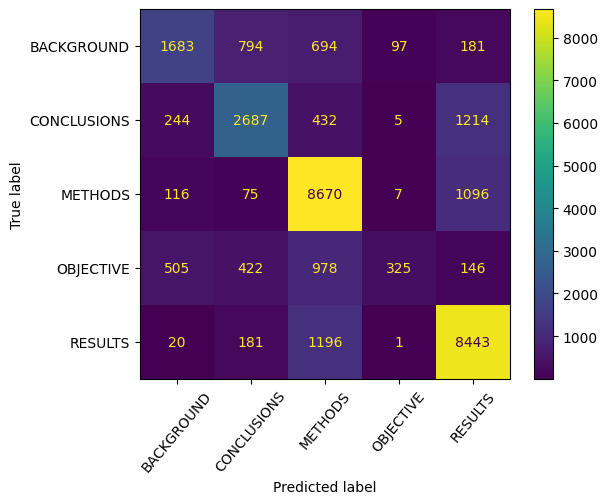

In [29]:
baseline_cm, baseline_report, baseline_metrics = get_cm_and_final_results(baseline_preds, val_label)

In [30]:
baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.655374,0.646069,0.724311,0.747126,0.762004,0.721832,0.706977,0.718647
recall,0.487968,0.586425,0.870132,0.136785,0.857941,0.721832,0.587850,0.721832
f1-score,0.559415,0.614804,0.790553,0.231234,0.807132,0.721832,0.600628,0.698925
support,3449.000000,4582.000000,9964.000000,2376.000000,9841.000000,0.721832,30212.000000,30212.000000


In [31]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Model Version 1 - Simple CNN based

In [32]:
np.percentile(word_counts, 95)

55.0

In [33]:
VOCAB_SIZE = 68000
NUM_TOKENS = 55
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=NUM_TOKENS,
)

I0000 00:00:1732634943.091833  639403 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [34]:
vectorizer.adapt(X_train)

In [35]:
len(vectorizer.get_vocabulary())

64841

In [36]:
sent = np.random.choice(X_train)

print(sent)

print(vectorizer(sent))

women were randomly assigned to daily @ mg/@ mg cmx , or ipt-sp .
tf.Tensor(
[   90     9    92   123     6   161    68    68 14149    16 15856     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(55,), dtype=int64)


In [37]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

In [38]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(NUM_CLASSES,activation = 'softmax')(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [39]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 49, 128)           114816    
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            24640 

In [40]:
if True:
    keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [41]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [42]:
len(X_train)/320

562.625

In [43]:
RUN1 = False # Change this to True to run this experiment as see the time difference

In [44]:
if RUN1:
    history_model_1 = model_1.fit(
        X_train,
        train_one_hot,
        validation_data = (X_val, val_one_hot),
        epochs=3,
        initial_epoch=0,
        callbacks=[create_tensorboard_callback('CNN', 'RUN1')],
        steps_per_epoch = 560,
        validation_steps = 560,
        batch_size=BATCH_SIZE
    )

In [45]:
if RUN1:
    model_1_preds = np.argmax(model_1.predict(X_val),axis=-1)
    model_1_preds, val_label

In [46]:
if RUN1:
    model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

In [47]:
if RUN1:
    model_1_report

## Processing data to tf Datasets to make faster calculations

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_train, train_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_test, test_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_val, val_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )


In [49]:
for line,label in train_dataset.take(1):
    print(np.concatenate((np.expand_dims(line.numpy(), axis=-1), label.numpy()),axis=-1)[:5])

[[b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'
  0.0 0.0 0.0 1.0 0.0]
 [b'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'
  0.0 0.0 1.0 0.0 0.0]
 [b'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'
  0.0 0.0 1.0 0.0 0.0]
 [b'pain was assessed using the visual analog pain scale ( @-@ mm ) .'
  0.0 0.0 1.0 0.0 0.0]
 [b'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'
  0.0 0.0 1.0 0.0 0.0]]


2024-11-26 20:59:19.880324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-26 20:59:19.881552: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Updating model to fit in with new procedure

In [50]:
#Enabling mixed float
keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


In [51]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [52]:
def plot_model(model):
    return keras.utils.plot_model(
    model=model, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [53]:
if True:
    keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [54]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 49, 128)           114816    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 22, 64)            2464

In [55]:
history_model_1 = model_1.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('CNN', 'RUN2')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/CNN/RUN2
Epoch 1/3


2024-11-26 20:59:22.457490: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1732634962.671094  639555 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732634964.780647  639545 service.cc:148] XLA service 0x7f54e00035f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732634964.781201  639545 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-26 20:59:24.807866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732634965.020121  639545 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 46s 74ms/step - loss: 0.9176 - accuracy: 0.6233 - val_loss: 0.6940 - val_accuracy: 0.7347
Epoch 2/3
 13/562 [..............................] - ETA: 7s - loss: 0.7643 - accuracy: 0.7043

2024-11-26 21:00:07.111204: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


562/562 [==============================] - 12s 21ms/step - loss: 0.6637 - accuracy: 0.7427 - val_loss: 0.6184 - val_accuracy: 0.7653
Epoch 3/3
  3/562 [..............................] - ETA: 25s - loss: 0.5954 - accuracy: 0.7604

2024-11-26 21:00:19.106609: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


562/562 [==============================] - 10s 18ms/step - loss: 0.6143 - accuracy: 0.7670 - val_loss: 0.5703 - val_accuracy: 0.7856


2024-11-26 21:00:29.095602: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-26 21:00:29.105951: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [56]:
model_1_preds = np.argmax(model_1.predict(val_dataset), axis=-1)

945/945 [==============================] - 4s 4ms/step


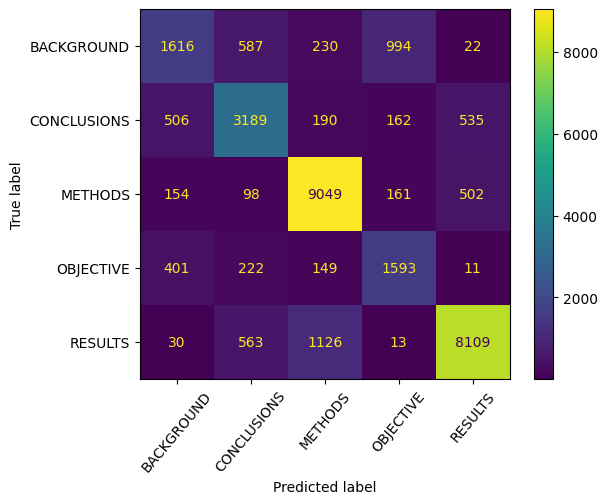

In [57]:
model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

In [58]:
model_1_report - baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,-0.058403,0.038413,0.117927,-0.202138,0.121426,0.057858,0.003445,0.061706
recall,-0.019426,0.109559,0.038037,0.533670,-0.033940,0.057858,0.125580,0.057858
f1-score,-0.034399,0.075381,0.083408,0.370011,0.045550,0.057858,0.107990,0.078950
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.057858,0.000000,0.000000


# Model Version 2 - Pretrained Embeddings

In [59]:
universal_sentence_encoder = hub.KerasLayer(
    handle="https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    trainable=False,
    name='USE'
)

In [60]:
universal_sentence_encoder([' what joja', 'n'])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.04555983, -0.00660281, -0.01276617, ..., -0.04721962,
         0.07622743,  0.01372085],
       [-0.02442588, -0.03740193, -0.01249437, ..., -0.07511895,
         0.04019829,  0.00873134]], dtype=float32)>

In [61]:
class USE(keras.layers.Layer):

    def __init__(self, encoder):

        super().__init__()
        self.encoder = encoder
    
    def call(self, inputs):
        return self.encoder(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder,
        })

        return config

In [62]:
# model_2 = keras.Sequential([
#     keras.layers.Input(shape=[], dtype=tf.string),
#     USE(universal_sentence_encoder),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(NUM_CLASSES),
#     keras.layers.Activation('softmax', dtype=tf.float32),
# ])

# model_2.compile(
#     optimizer= keras.optimizers.Adam(), 
#     loss = keras.losses.CategoricalCrossentropy(), 
#     metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
#     )

In [63]:
inputs = keras.layers.Input(shape=[], dtype=tf.string)

x = universal_sentence_encoder(inputs, training=False)
# x = keras.layers.Conv1D(128,7, activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.Conv1D(64,3,activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_2 = keras.Model(inputs,outputs)

model_2.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [64]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
 activation_1 (Activation)   (None, 5)                 0         
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [65]:
history_model_2 = model_2.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    #callbacks=[create_tensorboard_callback('USE', 'RUN1')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Epoch 1/3


562/562 [==============================] - 23s 31ms/step - loss: 0.9192 - accuracy: 0.6511 - val_loss: 0.7976 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7671 - accuracy: 0.7020 - val_loss: 0.7536 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.7494 - accuracy: 0.7141 - val_loss: 0.7367 - val_accuracy: 0.7138


2024-11-26 21:01:40.032319: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


945/945 [==============================] - 22s 23ms/step


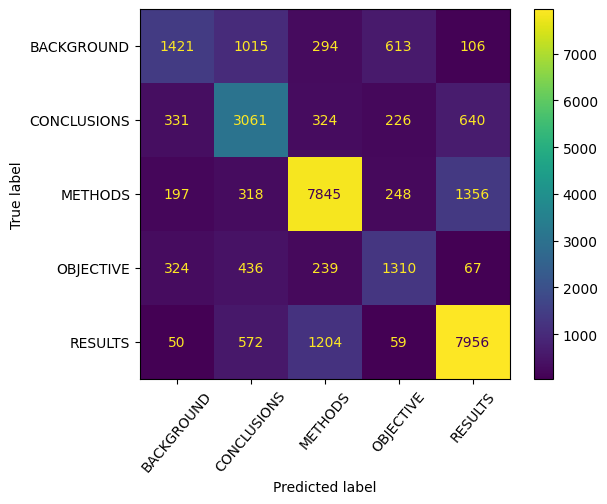

In [66]:
model_2_preds = np.argmax(model_2.predict(val_dataset), axis=-1)
model_2_cm, model_2_report, model_2_metrics = get_cm_and_final_results(model_2_preds, val_label)

In [67]:
model_2_report - baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,-0.043665,-0.079427,0.067633,-0.213739,0.023774,-0.007116,-0.049085,-0.003790
recall,-0.075964,0.081624,-0.082798,0.414562,-0.049487,-0.007116,0.057587,-0.007116
f1-score,-0.067038,-0.001623,-0.000921,0.310984,-0.010177,-0.007116,0.046245,0.012939
support,0.000000,0.000000,0.000000,0.000000,0.000000,-0.007116,0.000000,0.000000


# Model Version 3 - Character Level Embeddings

In [68]:
X_train_chars = [" ".join(list(sentence)) for sentence in X_train]
X_val_chars = [" ".join(list(sentence)) for sentence in X_val]
X_test_chars = [" ".join(list(sentence)) for sentence in X_test]

In [69]:
random_i = np.random.randint(len(X_train))
X_train[random_i], X_train_chars[random_i]

('we aimed to determined the usual dosage of statin in clinical practice and the adherence to recommended target concentration of ldl-cholesterol .',
 'w e   a i m e d   t o   d e t e r m i n e d   t h e   u s u a l   d o s a g e   o f   s t a t i n   i n   c l i n i c a l   p r a c t i c e   a n d   t h e   a d h e r e n c e   t o   r e c o m m e n d e d   t a r g e t   c o n c e n t r a t i o n   o f   l d l - c h o l e s t e r o l   .')

<Axes: ylabel='Frequency'>

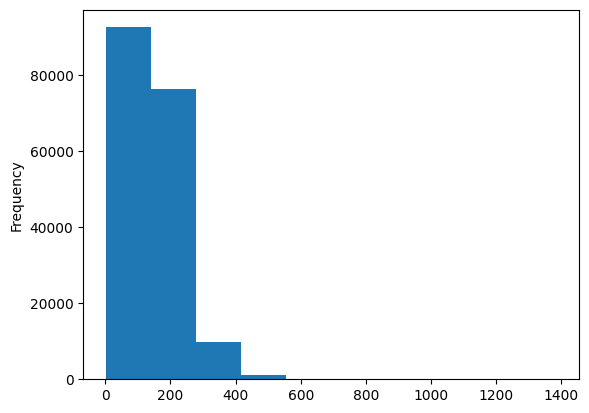

In [70]:
pd.Series(X_train).apply(len).plot.hist()

In [71]:
np.percentile(pd.Series(X_train).apply(len).to_numpy(), 95)

290.0

In [ ]:
character_vectorizer = TextVectorization(
    max_tokens = 29,
    split='character',
    output_sequence_length=290,
    standardize="lower_and_strip_punctuation",
)

: 

In [ ]:
character_vectorizer.adapt(X_train_chars)

In [ ]:
vocab = character_vectorizer.get_vocabulary()

In [ ]:
vocab

['',
 '[UNK]',
 ' ',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 'y',
 'w',
 'v',
 'b',
 'k',
 'x',
 'z',
 'q',
 'j']

In [ ]:
character_vectorizer(X_val[0])

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 5, 19,  3,  2, 10,  3,  7, 10,  5,  4,  5, 26,  6,  4,  5,  8,  7,
        2,  4,  8,  2,  6, 10, 15,  3,  9, 19,  5, 13, 13, 17, 10,  2, 18,
       17, 16,  5, 19,  6,  4, 17, 10,  2,  6,  7, 11,  2,  6,  2, 15,  8,
       10,  5,  4,  5, 22,  3,  2, 10, 15, 17,  4, 17, 16,  2, 18, 17,  7,
       19,  6, 13,  2, 12, 17, 13,  4, 17,  9,  3,  2,  9,  3, 10, 17, 13,
        4,  2,  6,  9,  3,  2, 12,  8, 16, 16,  8,  7,  2,  5,  7,  2, 15,
        6,  4,  5,  3,  7,  4, 10,  2, 21,  5,  4, 14,  2,  9,  3, 18,  9,
        6, 12,  4,  8,  9, 20,  2,  6, 10,  4, 14, 16,  6,  2,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [ ]:
EMBEDDING_DIMENSIONS = 25
model_3_embedding = Embedding(
    input_dim=29,
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)
x = model_3_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_3 = keras.Model(inputs,outputs)

model_3.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [ ]:
plot_model(model_3)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
train_dataset_chars = tf.data.Dataset.from_tensor_slices(
    tensors=(X_train_chars, train_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset_chars = tf.data.Dataset.from_tensor_slices(
    tensors=(X_test_chars, test_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset_chars = tf.data.Dataset.from_tensor_slices(
    tensors=(X_val_chars, val_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).cache().prefetch(
                buffer_size=tf.data.AUTOTUNE
                )


In [ ]:
history_model_3 = model_3.fit(
    train_dataset_chars,
    validation_data=(val_dataset_chars),
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('CHARS', 'RUN1')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/CHARS/RUN1
Epoch 1/3
 56/562 [=>............................] - ETA: 3:04 - loss: 1.4814 - accuracy: 0.3265

945/945 [==============================] - 7s 7ms/step


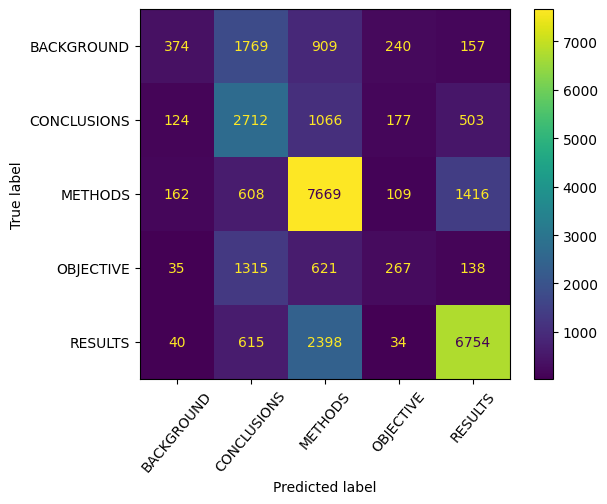

In [ ]:
model_3_preds = np.argmax(model_3.predict(val_dataset_chars), axis=-1)
model_3_cm, model_3_report, model_3_metrics = get_cm_and_final_results(model_3_preds, val_label)

In [ ]:
model_3_report - baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,-0.146530,-0.259689,-0.118688,-0.424273,-0.008881,-0.133457,-0.191612,-0.131516
recall,-0.379530,0.005456,-0.100462,-0.024411,-0.171629,-0.133457,-0.134115,-0.133457
f1-score,-0.380639,-0.147258,-0.112691,-0.064516,-0.088965,-0.133457,-0.158814,-0.137005
support,0.000000,0.000000,0.000000,0.000000,0.000000,-0.133457,0.000000,0.000000
